In [93]:
%cd /content/drive/MyDrive/ImageCaptioning

/content/drive/.shortcut-targets-by-id/1T29Y68hwqYe4aONgWDX4qeaf22winbNJ/ImageCaptioning


In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow
from nltk.translate.bleu_score import sentence_bleu
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras

from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout, add, RepeatVector, Concatenate
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3

from keras import Input
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Dataset

In [96]:
df = pd.read_csv("data/captions.txt")
df

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...
40450,997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,A rock climber in a red shirt .


In [97]:
df_train = df.iloc[:7000 * 5 + 5,:]
df_test = df.iloc[7000 * 5 + 5:,:]
df_test = df_test.reset_index()

In [98]:
def plot_example(df, idx):
    # Plot image
    IMAGES_PATH = 'data/Images'
    image_name = df['image'][idx * 5]
    image = cv2.imread(os.path.join(IMAGES_PATH, image_name))
    print(f"Image's shape: {image.shape}")
    cv2_imshow(image)

    # Print captions
    print('Captions:')
    captions = df['caption'][5 * idx: 5 * idx + 5]
    for idx, values in captions.items():
        print(values)

In [99]:
# plot_example(df_train, 10)

# Tokenize

In [100]:
def caption_preprocessing(text, remove_digits=True):
    # Remove special character
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)

    # Tokenize
    text=text.split()

    # Convert to lower case
    text = [word.lower() for word in text]

    # Remove tokens with numbers in them
    text = [word for word in text if word.isalpha()]

    # Store as string
    text =  ' '.join(text)

    # insert '[START]', '[END]' cho chuỗi
    text = '[START] ' + text + ' [END]'
    return text

print(caption_preprocessing('chao .. ban $ hello980 it\'s a table.#'))

[START] chao ban its a table [END]


In [101]:
processed_df_train = df_train.copy(deep=True)
processed_df_train['caption'] = df_train['caption'].apply(caption_preprocessing)

In [102]:
word_counts = {}
for text in processed_df_train['caption']:
  words = text.split()
  for w in words:
    try:
      word_counts[w] +=1
    except:
        word_counts[w] = 1
print(len(word_counts))

8256


In [103]:
word_count_threshold = 5
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('Preprocessed words %d -> %d' % (len(word_counts), len(vocab)))


Preprocessed words 8256 -> 2762


In [104]:
i2w = {}
w2i = {}

id = 0
for w in vocab:
    w2i[w] = id
    i2w[id] = w
    id += 1

# Data generator

In [105]:
def data_generator(df, w2i, i2w, MAX_LENGTH, VOCAB_SIZE, BATCH_SIZE):

  X_image, X_cap, y = [], [], []
  n = 0
  while 1:
    for i in range(len(df) // 5):
        # Read image
        image_name = df['image'][i * 5]
        image = cv2.imread(os.path.join('data/Images', image_name))
        image = cv2.resize(image, (299, 299))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_input(image)

        # Read captions
        captions = df['caption'][5 * i: 5 * i + 5]
        for idx, cap in captions.items():
            # Encode the sequence
            seq = [w2i[word] for word in cap.split(' ') if word in w2i]

            for i in range(1, len(seq)):
                # Split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]

                # Padding input sequence
                in_seq = pad_sequences([in_seq], maxlen=MAX_LENGTH)[0]

                # Encode output sequence
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                # Store
                n += 1
                X_image.append(image)
                X_cap.append(in_seq)
                y.append(out_seq)


                if n == BATCH_SIZE:
                    yield ([np.array(X_image), np.array(X_cap)], np.array(y))
                    X_image, X_cap, y = [], [], []
                    n = 0

# Build model

In [106]:
@keras.saving.register_keras_serializable()
class ImageFeatureExtractionLayer(tf.keras.layers.Layer):
    def __init__(self, MAX_LENGTH):
        super().__init__()
        # Load pretrained model
        pretrained_model = InceptionV3()
        feature_extraction = Model(
            pretrained_model.input, pretrained_model.layers[-2].output)
        feature_extraction.trainable = False

        # Build a model to extract feature from image
        self.image_fe_model = Sequential([
            Input(shape=(299, 299, 3)),
            feature_extraction,
            RepeatVector(MAX_LENGTH),
            Dropout(0.2),
        ])

    def call(self, input):
        return self.image_fe_model(input)

    def get_config(self):
        config = super().get_config().copy()
        config.update({'image_fe_model': self.image_fe_model, })
        return config


In [107]:
@keras.saving.register_keras_serializable()
class TextFeatureExtractionLayer(tf.keras.layers.Layer):
    def __init__(self, VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH):
        super().__init__()
        # Build a model to extract feature from text
        self.text_fe_model = Sequential([
            Input(shape=(MAX_LENGTH,)),
            Embedding(VOCAB_SIZE, EMBEDDING_DIM, mask_zero=True),
        ])

    def call(self, input):
        return self.text_fe_model(input)

    def get_config(self):
        config = super().get_config().copy()
        config.update({'text_fe_model': self.text_fe_model})
        return config

In [108]:
@keras.saving.register_keras_serializable()
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, VOCAB_SIZE,
                 EMBEDDING_DIM,
                 MAX_LENGTH):
        super().__init__()
        # A decoder includes a image feature extractor and text feature extractor
        self.image_fe = ImageFeatureExtractionLayer(MAX_LENGTH)

        self.text_fe = TextFeatureExtractionLayer(
            VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH)

        self.concat_layer = Concatenate(axis=-1)

        self.model = Sequential([
            LSTM(256),
            Dense(256, activation='relu'),
            Dense(VOCAB_SIZE, activation='softmax')
        ])

    def call(self, input):
        image, text = input
        image_fe_in = self.image_fe(image)
        text_fe_in = self.text_fe(text)
        concat_fe = self.concat_layer([image_fe_in, text_fe_in])

        out = self.model(concat_fe)

        return out

    def get_config(self):
        config = super().get_config().copy()
        config.update({'image_fe': self.image_fe,
                       'text_fe': self.text_fe,
                       'model': self.model, }
                      )
        return config

In [109]:
@keras.saving.register_keras_serializable()
class Captioner(tf.keras.Model):
    def __init__(self, w2i, i2w,
                 VOCAB_SIZE, MAX_LENGTH,
                 EMBEDDING_DIM,
                 **kwargs):
        super().__init__()
        self.VOCAB_SIZE = VOCAB_SIZE
        self.MAX_LENGTH = MAX_LENGTH
        self.EMBEDDING_DIM = EMBEDDING_DIM

        self.w2i = w2i
        self.i2w = i2w
        self.decoder = DecoderLayer(VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH)

    def call(self, input):
        image, sequence = input
        pred = self.decoder([image, sequence])
        return pred

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'i2w': self.i2w,
            'w2i': self.w2i,
            'decoder': self.decoder,
            'MAX_LENGTH': self.MAX_LENGTH,
            'VOCAB_SIZE': self.VOCAB_SIZE,
            'EMBEDDING_DIM': self.EMBEDDING_DIM,
        })
        return config


    def generate_caption(self, image):
        image = cv2.resize(image, (299, 299))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)

        in_text = '[START]'
        for i in range(self.MAX_LENGTH):
            # Tokenize input
            sequence = [self.w2i[w] for w in in_text.split() if w in self.w2i]

            # Padding
            sequence = pad_sequences([sequence], maxlen=self.MAX_LENGTH)

            # Predict
            yhat = self([image, sequence])
            yhat = np.argmax(yhat)

            # Convert index into word
            word = self.i2w[str(yhat)]

            # Add predicted word add the end of the input text
            in_text += ' ' + word

            # If word is [END] token, then break
            if word == '[END]':
                break

        final = in_text.split()
        final = final[1: -1]
        final = ' '.join(final)

        return final

# Train

In [110]:
EMBEDDING_DIM = 200
MAX_LENGTH = 40
VOCAB_SIZE = len(vocab)
EPOCHS = 20
BATCH_SIZE = 16
STEPS = len(processed_df_train) // BATCH_SIZE

CHECKPOIN_PATH = 'checkpoints/par-inject-checkpoints/model-{epoch:02d}-{loss:.2f}.keras'
loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model = Captioner(w2i, i2w, VOCAB_SIZE,
                  MAX_LENGTH, EMBEDDING_DIM)


model.compile(loss=loss,
              optimizer=optimizer)




In [111]:

my_callback = ModelCheckpoint(filepath=CHECKPOIN_PATH,
                              save_best_only=False,
                              verbose=1)

generator = data_generator(processed_df_train, w2i, i2w,
                           MAX_LENGTH,
                           VOCAB_SIZE,
                           BATCH_SIZE)
model.fit(generator,
          epochs=EPOCHS,
          steps_per_epoch=STEPS,
          verbose=1,
          callbacks=[my_callback])


Epoch 1/20
2187/2187 [==============================] - ETA: 0s - loss: 5.4416
Epoch 1: saving model to checkpoints/par-inject-checkpoints/model-01-5.44.keras
2187/2187 [==============================] - 455s 204ms/step - loss: 5.4416
Epoch 2/20
2187/2187 [==============================] - ETA: 0s - loss: 4.6348
Epoch 2: saving model to checkpoints/par-inject-checkpoints/model-02-4.63.keras
2187/2187 [==============================] - 444s 203ms/step - loss: 4.6348
Epoch 3/20
2187/2187 [==============================] - ETA: 0s - loss: 4.2841
Epoch 3: saving model to checkpoints/par-inject-checkpoints/model-03-4.28.keras
2187/2187 [==============================] - 442s 202ms/step - loss: 4.2841
Epoch 4/20
2187/2187 [==============================] - ETA: 0s - loss: 4.0632
Epoch 4: saving model to checkpoints/par-inject-checkpoints/model-04-4.06.keras
2187/2187 [==============================] - 445s 204ms/step - loss: 4.0632
Epoch 5/20
2187/2187 [==============================] - ETA:

In [112]:
# Save model
model.save('models/par-inject-models/model.keras')

# Evaluate

In [113]:
# Load model
reconstructed_model = load_model('models/par-inject-models/model.keras')

In [126]:
def evaluate_bleu_score(df, model):
    metrics = {
        'uni_gram': [],
        'bi_gram': [],
        'tri_gram': [],
        'quad_gram': []
    }
    for i in tqdm(range(len(df))):

        # Read image
        image_name = df['image'][i * 5]
        image = cv2.imread(os.path.join('data/Images', image_name))
        image = cv2.resize(image, (299, 299))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = preprocess_input(image)

        # Read captions
        captions = df['caption'][5 * i: 5 * i + 5]
        reference_captions = [cap[1].split() for cap in captions.items()]


        candidate_caption = model.generate_caption(image).split()

        uni = sentence_bleu(reference_captions, candidate_caption, weights=(1, 0, 0, 0))
        bi = sentence_bleu(reference_captions, candidate_caption, weights=(0, 1, 0, 0))
        tri = sentence_bleu(reference_captions, candidate_caption, weights=(0, 0, 1, 0))
        quad = sentence_bleu(reference_captions, candidate_caption, weights=(0, 0, 0, 1))

        metrics['uni_gram'].append(uni)
        metrics['bi_gram'].append(bi)
        metrics['tri_gram'].append(tri)
        metrics['quad_gram'].append(quad)


    metrics['uni_gram'] = sum(metrics['uni_gram']) / len(metrics['uni_gram'])
    metrics['bi_gram'] = sum(metrics['bi_gram']) / len(metrics['bi_gram'])
    metrics['tri_gram'] = sum(metrics['tri_gram']) / len(metrics['tri_gram'])
    metrics['quad_gram'] = sum(metrics['quad_gram']) / len(metrics['quad_gram'])

    return metrics

In [ ]:
results = evaluate_bleu_score(df_test, reconstructed_model)

In [ ]:
results

# Testing

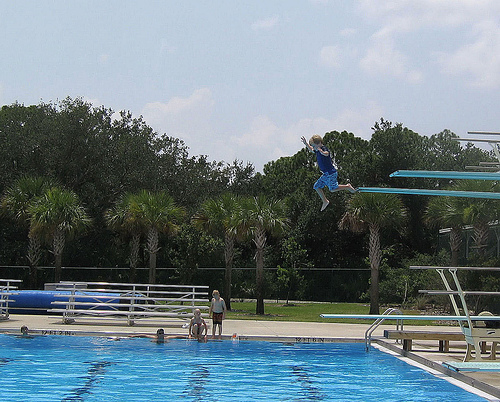

Captions:
A boy descends off the end of a high diving board .
A child jumps off a high diving board into the pool .
A kid jumps off the diving board and into the swimming pool below .
A little kid is jumping off a high dive at the pool .
The boy is jumping off a high diving board into the pool .
Predicted caption:
a man in a blue shirt is jumping on a pool


In [130]:
# Plot image
idx = 45
image_name = df['image'][idx * 5]
image = cv2.imread(os.path.join('data/Images', image_name))
cv2_imshow(image)

# Print captions
print('Captions:')
captions = df['caption'][5 * idx: 5 * idx + 5]
for idx, values in captions.items():
    print(values)

print("Predicted caption:")
print(reconstructed_model.generate_caption(image))